In [0]:
# パッケージのインポート
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from tensorflow.losses import huber_loss

Using TensorFlow backend.


In [0]:
# パラメータの準備
NUM_EPISODES = 500 # エピソード数
MAX_STEPS = 200 # 最大ステップ数
GAMMA = 0.99 # 時間割引率
WARMUP = 10 # 無操作ステップ数

# 探索パラメータ
E_START = 1.0 # εの初期値
E_STOP = 0.01 # εの最終値
E_DECAY_RATE = 0.001 # εの減衰率

# メモリパラメータ
MEMORY_SIZE = 10000 # 経験メモリのサイズ
BATCH_SIZE = 32 # バッチサイズ

In [0]:
# 行動価値関数の定義
class QNetwork:
    # 初期化
    def __init__(self, state_size, action_size):
        # モデルの作成
        self.model = Sequential()
        self.model.add(Dense(16, activation='relu', input_dim=state_size))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        
        # モデルのコンパイル
        self.model.compile(loss=huber_loss, optimizer=Adam(lr=0.001))

In [0]:
# 経験メモリの定義
class Memory():
    # 初期化
    def __init__(self, memory_size):
        self.buffer = deque(maxlen=memory_size)

    # 経験の追加
    def add(self, experience):
        self.buffer.append(experience)

    # バッチサイズ分の経験をランダムに取得
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    # 経験メモリのサイズ
    def __len__(self):
        return len(self.buffer)

In [0]:
# 環境の作成
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0] # 行動数
action_size = env.action_space.n # 状態数

# main-networkの作成
main_qn = QNetwork(state_size, action_size)

# target-networkの作成
target_qn = QNetwork(state_size, action_size)

# 経験メモリの作成
memory = Memory(MEMORY_SIZE)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# 学習の開始

# 環境の初期化
state = env.reset()
state = np.reshape(state, [1, state_size])

# エピソード数分のエピソードを繰り返す
total_step = 0 # 総ステップ数
success_count = 0 # 成功数
for episode in range(1, NUM_EPISODES+1):
    step = 0 # ステップ数
    
    # target-networkの更新
    target_qn.model.set_weights(main_qn.model.get_weights())
    
    # 1エピソードのループ
    for _ in range(1, MAX_STEPS+1):
        step += 1
        total_step += 1

        # εを減らす
        epsilon = E_STOP + (E_START - E_STOP)*np.exp(-E_DECAY_RATE*total_step)
        
        # ランダムな行動を選択
        if epsilon > np.random.rand():
            action = env.action_space.sample()
        # 行動価値関数で行動を選択
        else:
            action = np.argmax(main_qn.model.predict(state)[0])

        # 行動に応じて状態と報酬を得る
        next_state, _, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # エピソード完了時
        if done:
            # 報酬の指定
            if step >= 190:
                success_count += 1
                reward = 1
            else:
                success_count = 0
                reward = 0
            
            # 次の状態に状態なしを代入
            next_state = np.zeros(state.shape)
            
            # 経験の追加
            if step > WARMUP:
                memory.add((state, action, reward, next_state))                        
        # エピソード完了でない時
        else:
            # 報酬の指定
            reward = 0
                
            # 経験の追加
            if step > WARMUP:
                memory.add((state, action, reward, next_state))
            
            # 状態に次の状態を代入
            state = next_state

        # 行動価値関数の更新
        if len(memory) >= BATCH_SIZE:
            # ニューラルネットワークの入力と出力の準備
            inputs = np.zeros((BATCH_SIZE, 4)) # 入力(状態)
            targets = np.zeros((BATCH_SIZE, 2)) # 出力(行動ごとの価値)

            # バッチサイズ分の経験をランダムに取得
            minibatch = memory.sample(BATCH_SIZE)
            
            # ニューラルネットワークの入力と出力の生成
            for i, (state_b, action_b, reward_b, next_state_b) in enumerate(minibatch):
                
                # 入力に状態を指定
                inputs[i] = state_b
                
                # 採った行動の価値を計算
                if not (next_state_b == np.zeros(state_b.shape)).all(axis=1):
                    target = reward_b + GAMMA * np.amax(target_qn.model.predict(next_state_b)[0])
                else:
                    target = reward_b

                # 出力に行動ごとの価値を指定
                targets[i] = main_qn.model.predict(state_b)
                targets[i][action_b] = target # 採った行動の価値

            # 行動価値関数の更新
            main_qn.model.fit(inputs, targets, epochs=1, verbose=0)
        
        # エピソード完了時
        if done:
            # エピソードループを抜ける
            break
           
    # エピソード完了時のログ表示
    print('エピソード: {}, ステップ数: {}, epsilon: {:.4f}'.format(episode, step, epsilon))

    # 5回連続成功で学習終了
    if success_count >= 5:
        break

    # 環境のリセット
    state = env.reset()
    state = np.reshape(state, [1, state_size])        







エピソード: 1, ステップ数: 15, epsilon: 0.9853
エピソード: 2, ステップ数: 20, epsilon: 0.9659
エピソード: 3, ステップ数: 18, epsilon: 0.9489


エピソード: 4, ステップ数: 27, epsilon: 0.9239
エピソード: 5, ステップ数: 29, epsilon: 0.8978
エピソード: 6, ステップ数: 14, epsilon: 0.8854
エピソード: 7, ステップ数: 23, epsilon: 0.8655
エピソード: 8, ステップ数: 12, epsilon: 0.8553
エピソード: 9, ステップ数: 21, epsilon: 0.8377
エピソード: 10, ステップ数: 16, epsilon: 0.8246
エピソード: 11, ステップ数: 20, epsilon: 0.8085
エピソード: 12, ステップ数: 13, epsilon: 0.7982
エピソード: 13, ステップ数: 15, epsilon: 0.7864
エピソード: 14, ステップ数: 10, epsilon: 0.7787
エピソード: 15, ステップ数: 16, epsilon: 0.7665
エピソード: 16, ステップ数: 12, epsilon: 0.7575
エピソード: 17, ステップ数: 12, epsilon: 0.7486
エピソード: 18, ステップ数: 11, epsilon: 0.7405
エピソード: 19, ステップ数: 13, epsilon: 0.7310
エピソード: 20, ステップ数: 12, epsilon: 0.7224
エピソード: 21, ステップ数: 55, epsilon: 0.6843
エピソード: 22, ステップ数: 18, epsilon: 0.6723
エピソード: 23, ステップ数: 25, epsilon: 0.6559
エピソード: 24, ステップ数: 42, epsilon: 0.6294
エピソード: 25, ステップ数: 18, epsilon: 0.6183
エピソード: 26, ステップ数: 23, epsilon: 0.6045
エピソード: 27, ステ

In [0]:
# ディスプレイ設定のインストール
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install pyglet==1.3.2
!pip install pyopengl
!pip install pyvirtualdisplay

# ディスプレイ設定の適用
from pyvirtualdisplay import Display
import os
disp = Display(visible=0, size=(1024, 768))
disp.start()
os.environ['DISPLAY'] = ':' + str(disp.display) + '.' + str(disp.screen)

     |████████████████████████████████| 1.0MB 1.5MB/s 
  Found existing installation: pyglet 1.4.6
    Uninstalling pyglet-1.4.6:
      Successfully uninstalled pyglet-1.4.6


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


In [0]:
# 評価
frames = [] #　アニメーションフレーム

# 環境のリセット
state = env.reset()
state = np.reshape(state, [1, state_size])

# 1エピソードのループ
step = 0 # ステップ数
for step in range(1, MAX_STEPS+1):
    step += 1
    
    # アニメーションフレームの追加
    frames.append(env.render(mode='rgb_array'))
    
    # 最適行動を選択
    action = np.argmax(main_qn.model.predict(state)[0])

    # 行動に応じて状態と報酬を得る
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])

    # エピソード完了時
    if done:
        # 次の状態に状態なしを代入
        next_state = np.zeros(state.shape)
        
        # エピソードループを抜ける
        break
    else:
        # 状態に次の状態を代入
        state = next_state

# エピソード完了時のログ表示
print('ステップ数: {}'.format(step))

ステップ数: 119


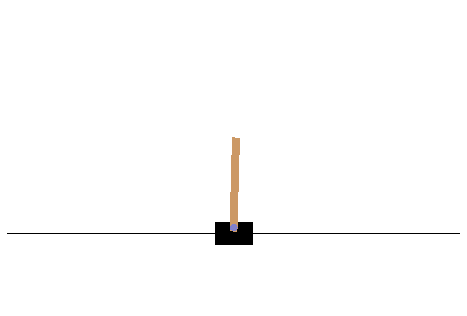

In [13]:
# JSAnimationのインストール
!pip install JSAnimation

# パッケージのインポート
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

# アニメーション再生の定義
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

# アニメーションの定期処理
def animate(i):
    patch.set_data(frames[i])

# アニメーション再生
anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())   